/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Best hyperparameters: (0.3, 0.99, 0.2, 0.1)


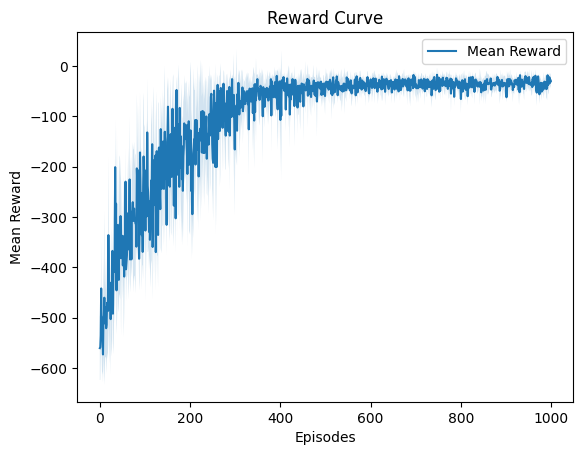

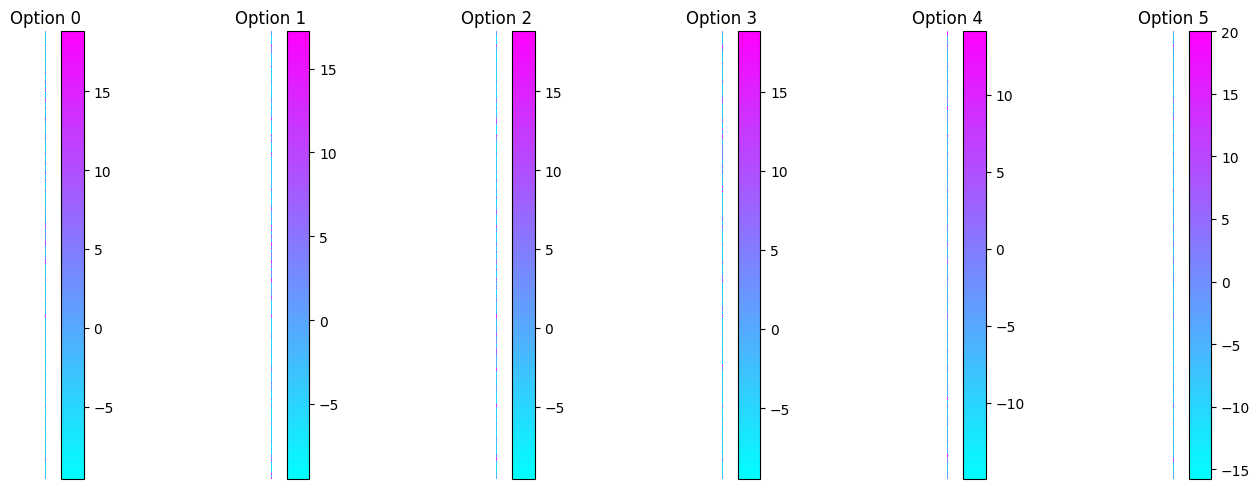

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Function to execute the learned options
def execute_option(option, state):
    if option == 0:  # Move to location 1
        return 2  # Move East
    elif option == 1:  # Move to location 2
        return 3  # Move West
    elif option == 2:  # Move to location 3
        return 1  # Move North
    elif option == 3:  # Move to location 4
        return 0  # Move South
    elif option == 4:  # Pick up passenger
        return 4  # Pick up
    elif option == 5:  # Drop off passenger
        return 5  # Drop off

# Function to choose an option using epsilon-greedy policy
def choose_option(Q, state, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(6)  # Choose a random option
    else:
        return np.argmax(Q[state])  # Choose the option with the highest Q-value

# Intra-option Q-learning function
def intra_option_q_learning(env, num_episodes, alpha, gamma, epsilon, option_epsilon):
    Q = np.zeros((env.observation_space.n, 6))  # Q-table for options

    rewards = np.zeros(num_episodes)

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        while True:
            option = choose_option(Q, state, option_epsilon)
            action = execute_option(option, state)
            next_state, reward, done, _ = env.step(action)

            # Update the Q-values for the chosen option
            Q[state][option] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][option])

            if done:
                break

            state = next_state
            total_reward += reward

        rewards[episode] = total_reward

    return Q, rewards

# Function for hyperparameter tuning
def hyperparameter_tuning(env, num_runs, num_episodes, alphas, gammas, epsilons, option_epsilons):
    best_reward = float('-inf')
    best_params = None
    all_rewards = []

    for alpha in alphas:
        for gamma in gammas:
            for epsilon in epsilons:
                for option_epsilon in option_epsilons:
                    total_rewards = []

                    for _ in range(num_runs):
                        Q, rewards = intra_option_q_learning(env, num_episodes, alpha, gamma, epsilon, option_epsilon)
                        total_rewards.append(rewards)

                    avg_reward = np.mean(total_rewards)
                    if avg_reward > best_reward:
                        best_reward = avg_reward
                        best_params = (alpha, gamma, epsilon, option_epsilon)
                    all_rewards.append(total_rewards)

    return best_params, all_rewards

# Function to plot reward curve
def plot_rewards(rewards):
    mean_rewards = np.mean(rewards, axis=0)
    std_rewards = np.std(rewards, axis=0)
    episodes = np.arange(len(mean_rewards))
    plt.plot(episodes, mean_rewards, label='Mean Reward')
    plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2)
    plt.xlabel('Episodes')
    plt.ylabel('Mean Reward')
    plt.title('Reward Curve')
    plt.legend()
    plt.show()

# Function to plot Q-table
def plot_q_table(Q):
    plt.figure(figsize=(15, 5))
    for i in range(Q.shape[1]):
        plt.subplot(1, Q.shape[1], i+1)
        plt.imshow(Q[:, i].reshape((env.observation_space.n, 1)), cmap='cool', interpolation='nearest')
        plt.title("Option " + str(i))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main code
env = gym.make('Taxi-v3')
num_runs = 5
num_episodes = 1000
alphas = [0.1, 0.2, 0.3]
gammas = [0.95, 0.99, 0.999]
epsilons = [0.1, 0.2, 0.3]
option_epsilons = [0.1, 0.2, 0.3]

best_params, all_rewards = hyperparameter_tuning(env, num_runs, num_episodes, alphas, gammas, epsilons, option_epsilons)
print("Best hyperparameters:", best_params)

# Plot reward curve for the best set of hyperparameters
plot_rewards(all_rewards[-1])

# Taking the last Q-table from the last run to plot
best_alpha, best_gamma, best_epsilon, best_option_epsilon = best_params
Q, _ = intra_option_q_learning(env, num_episodes, best_alpha, best_gamma, best_epsilon, best_option_epsilon)

# Plot Q-table for all options
plt.figure(figsize=(15, 5))
for i in range(Q.shape[1]):
    plt.subplot(1, Q.shape[1], i+1)
    plt.imshow(Q[:, i].reshape((env.observation_space.n, 1)), cmap='cool', interpolation='nearest')
    plt.title("Option " + str(i))
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.show()
